# K Nearest Neighbor Evaluation

In [1]:
import os
import numpy as np
import torch

from datetime import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from bring_features_and_file_paths import get_BirdNET_detections
from bring_features_and_file_paths import get_spectrogram_time_mark_in_file
from bring_features_and_file_paths import bring_features_and_file_paths
from bring_features_and_file_paths import from_spectrogram_path_to_BirdNET_output_path

import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

In [27]:
features_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/features_second_pass'
indices_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/indices_first_pass/exclude_indices.pth'

# clusters_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/clusters_third_pass'
# include_indices_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/indices_third_pass/include_indices.pth'
# label_predictions_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/indices_third_pass/label_predictions.pth'
# indices_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/indices_third_pass/indices.pth'

In [28]:
feats, fpaths = bring_features_and_file_paths(features_path, sub_sample=None)

exclude_indices = set(torch.load(indices_path))
# exclude_indices = set(torch.load(indices_path)) | altered_gain_indices
include_indices = [idx for idx in range(len(feats)) if idx not in exclude_indices]
feats = feats[include_indices]
fpaths = fpaths[include_indices]

indices = torch.randperm(feats.size()[0])
feats=feats[indices]
fpaths=fpaths[indices]

feats = PCA(n_components=384).fit_transform(feats)

We have 2136286 feature vectors.


KeyboardInterrupt: 

In [20]:
np.save('/projects/MultiActiveAI/Samir_VICReg_Outputs/pca_feats.npy', feats)
np.save('/projects/MultiActiveAI/Samir_VICReg_Outputs/pca_fpaths.npy', fpaths)

KeyboardInterrupt: 

In [70]:
feats = np.load('/projects/MultiActiveAI/Samir_VICReg_Outputs/pca_feats.npy')
fpaths = np.load('/projects/MultiActiveAI/Samir_VICReg_Outputs/pca_fpaths.npy')

In [71]:
feats.shape

(1978138, 384)

In [72]:
device_to_location = {
    4862: "Grassland 1",
    4879: "Grassland 2",
    23734: "Forest 1",
    23764: "Forest 2",
    23795: "Forest 3",
    23771: "Forest 4",
    23757: (datetime(month=7, day=14, year=2021, hour=14, second=55), ["Forest 3", "Forest 5"]),
    23700: "Forest 6",
}

In [73]:
aspect='detection'

vectors=[]
labels=[]
BirdNET_BASE_PATH = '/grand/projects/BirdAudio/Soundscapes/BirdNET_Output'
Spectrograms_BASE_PATH = '/grand/projects/BirdAudio/Soundscapes/Second_Filtered_Spectrograms/'
# Spectrograms_BASE_PATH = '/grand/projects/BirdAudio/Soundscapes/First_Filtered_Spectrograms'
spectrogram_duration = 9.0
for k, (fpath, feat) in enumerate(tqdm(zip(fpaths,feats), total=len(feats))):
    file_path = ''.join([chr(int(x)) for x in fpath]).replace('~','')
    BirdNET_PATH = from_spectrogram_path_to_BirdNET_output_path(fpath)

    try:
        start_time = get_spectrogram_time_mark_in_file(fpath, spectrogram_duration)

        interval = (start_time, start_time + spectrogram_duration)
        data_elements = get_BirdNET_detections(os.path.join(BirdNET_BASE_PATH, BirdNET_PATH), interval, confidence_threshold = 0.0)


        for data_element in data_elements:
            device=int(data_element['device'])
            if device!=23788:
                if aspect=='location':
                    location = device_to_location[device]
                    if isinstance(location, tuple):
                        date = datetime(month=data_element['month'], day=data_element['day'], year=data_element['year'], hour=data_element['hour'], second=data_element['second'])
                        if date < location[0]:
                            data_element['location'] = location[1][0]
                        else:
                            data_element['location'] = location[1][1]
                    else:
                        data_element['location'] = location

                vectors.append(np.array(feat))
                labels.append(data_element[aspect])

    except:
        print("Something was wrong with")
        print(file_path)


    if k > 200000:
        break

vectors=np.array(vectors)
labels=np.array(labels)
unique_labels=np.unique(labels)
aux=[]
for label in labels:
    aux.append(np.where(unique_labels==label)[0].item())
    
labels=np.array(aux)

 10%|█         | 200001/1978138 [09:10<1:21:33, 363.38it/s]


In [74]:
if aspect=='detection':
    mask=np.array([unique_labels=='Blue Jay'])
    mask=np.logical_or(mask,np.array([unique_labels=='Eastern Wood-Pewee']))
#     mask=np.logical_or(mask,np.array([unique_labels=='Great Crested Flycatcher']))
#     mask=np.logical_or(mask,np.array([unique_labels=='Hairy Woodpecker']))
    mask=np.logical_or(mask,np.array([unique_labels=='Indigo Bunting']))
    mask=np.logical_or(mask,np.array([unique_labels=='Ovenbird']))
#     mask=np.logical_or(mask,np.array([unique_labels=='Red-eyed Vireo']))
    mask=np.logical_or(mask,np.array([unique_labels=='Scarlet Tanager']))
#     mask=np.logical_or(mask,np.array([unique_labels=='Tree Swallow']))
    mask=np.logical_or(mask,np.array([unique_labels=='No detection']))

    chosen_labels=np.where(mask[0])[0]
    chosen_labels

    def find_indices(A, B):
        indices = np.where(np.isin(A, B))
        return indices

    indices=find_indices(labels, chosen_labels)[0]

    vectors = vectors[indices]
    labels = labels[indices]

In [75]:
vectors.shape

(168498, 384)

In [76]:
labels.shape

(168498,)

In [77]:
unique_labels

array(['American Crow', 'American Goldfinch', 'American Redstart',
       'American Robin', 'Baltimore Oriole', 'Barn Swallow',
       'Bay-breasted Warbler', 'Belted Kingfisher',
       'Black-and-white Warbler', 'Black-capped Chickadee',
       'Black-crowned Night-Heron', 'Black-throated Green Warbler',
       'Blackburnian Warbler', 'Blackpoll Warbler', 'Blue Jay',
       'Blue-gray Gnatcatcher', 'Blue-headed Vireo', 'Brown Thrasher',
       'Brown-headed Cowbird', 'Canada Goose', 'Cape May Warbler',
       'Caspian Tern', 'Cedar Waxwing', 'Chestnut-sided Warbler',
       'Chimney Swift', 'Chipping Sparrow', 'Common Grackle',
       'Common Nighthawk', 'Common Yellowthroat', "Cooper's Hawk",
       'Dark-eyed Junco', 'Double-crested Cormorant', 'Downy Woodpecker',
       'Eastern Bluebird', 'Eastern Kingbird', 'Eastern Phoebe',
       'Eastern Towhee', 'Eastern Wood-Pewee', 'European Starling',
       'Field Sparrow', 'Golden-winged Warbler', 'Gray Catbird',
       'Gray-cheeked Th

In [78]:
performances=[]
performances_per_label=[]
# jumps=list(np.arange(1,21,4))
jumps=[5,10,15,20]
for n in tqdm(jumps):
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(vectors, labels)
    label_predictions=neigh.predict(vectors)
    performances.append(np.sum(label_predictions==labels)/labels.shape[0])
    
    per_label_performance=[]
    for label in range(len(unique_labels)):
        indices=np.where(labels==label)
        per_label_performance.append(np.sum(label_predictions[indices]==label)/indices[0].shape[0])
        
    per_label_performance=np.array(per_label_performance)
    performances_per_label.append(per_label_performance)

performances=np.array(performances)
performances_per_label=np.array(performances_per_label)

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_604172/4281146875.py:14: RuntimeWarning: invalid value encountered in long_scalars
  per_label_performance.append(np.sum(label_predictions[indices]==label)/indices[0].shape[0])
 25%|██▌       | 1/4 [09:13<27:41, 553.71s/it]/tmp/ipykernel_604172/4281146875.py:14: RuntimeWarning: invalid value encountered in long_scalars
  per_label_performance.append(np.sum(label_predictions[indices]==label)/indices[0].shape[0])
 50%|█████     | 2/4 [17:28<17:17, 518.90s/it]/tmp/ipykernel_604172/4281146875.py:14: RuntimeWarning: invalid value encountered in long_scalars
  per_label_performance.append(np.sum(label_predictions[indices]==label)/indices[0].shape[0])
 75%|███████▌  | 3/4 [25:45<08:28, 508.98s/it]/tmp/ipykernel_604172/4281146875.py:14: RuntimeWarning: invalid value encountered in long_scalars
  per_label_performance.append(np.sum(label_predictions[indices]==label)/indices[0].shape[0])
100%|██████████| 4/4 [33:58<00:00, 509.69s/it]


In [79]:
np.save(f"{aspect}_performances.npy", performances)
np.save(f"{aspect}_performances_per_label.npy", performances_per_label)

In [64]:
aspect = 'location'
unique_labels = [*[f'Forest {i}' for i in range(1, 7)], *[f'Grassland {i}' for i in range(1, 3)]]
jumps = [5, 10, 15, 20]

performances = np.load(f"{aspect}_performances.npy")
performances_per_label = np.load(f"{aspect}_performances_per_label.npy")

Text(0, 0.5, 'Performance')

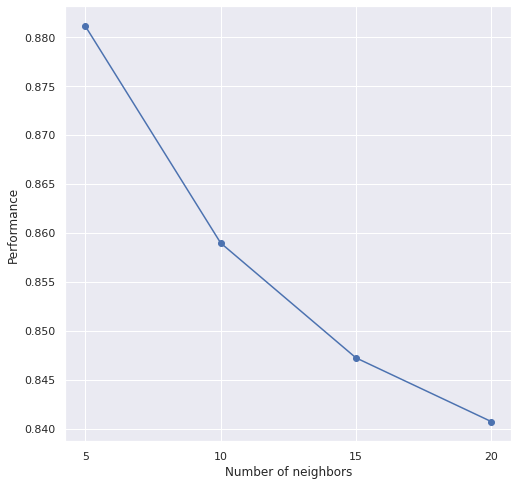

In [80]:
#aux=np.array([int(j+1) for j in range(jumps)])
aux=jumps
plt.figure(figsize=(8,8))
plt.plot(aux, performances, marker='o')
plt.xticks(aux)
plt.xlabel('Number of neighbors')
plt.ylabel('Performance')

Text(66.5, 0.5, 'Number of neighbors')

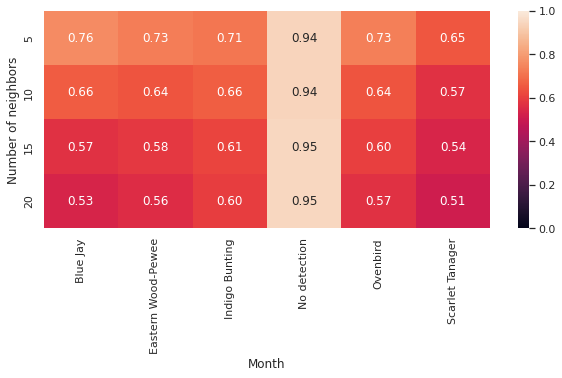

In [85]:
# sns.set(font_scale=20)
# sns.set (rc = {'figure.figsize':(8,4)}) # detection
# sns.set (rc = {'figure.figsize':(22,4)}) # hour
sns.set (rc = {'figure.figsize':(10,4)}) # location
# sns.set (rc = {'figure.figsize':(15,4)}) # week
# sns.set (rc = {'figure.figsize':(5,4)}) # month

sns.heatmap(performances_per_label[:,chosen_labels], xticklabels=unique_labels[chosen_labels], yticklabels=aux, annot=True, fmt=".2f", vmin=0.0, vmax=1.0)
# sns.heatmap(performances_per_label, xticklabels=unique_labels, yticklabels=aux, annot=True, fmt=".2f", vmin=0.0, vmax=1.0)
#plt.xlabel('Devices')
plt.xlabel('Month')
plt.ylabel('Number of neighbors')

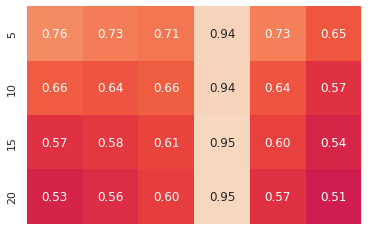

In [91]:
# sns.set(font_scale=20)
sns.set (rc = {'figure.figsize':(6,4)}) # detection
# sns.set (rc = {'figure.figsize':(22,4)}) # hour
# sns.set (rc = {'figure.figsize':(10,4)}) # location
# sns.set (rc = {'figure.figsize':(14,4)}) # week
# sns.set (rc = {'figure.figsize':(4,4)}) # month
#sns.set (rc = {'figure.figsize':(55, 10)})
# sns.heatmap(performances_per_label[:,chosen_labels], xticklabels=unique_labels[chosen_labels], yticklabels=False, annot=True, fmt=".2f", vmin=0.0, vmax=1.0, cbar=False)
# sns.heatmap(performances_per_label[:,chosen_labels], xticklabels=False, yticklabels=aux, annot=True, fmt=".2f", vmin=0.0, vmax=1.0, cbar=False)
sns.heatmap(performances_per_label[:,chosen_labels], xticklabels=False, yticklabels=aux, annot=True, fmt=".2f", vmin=0.0, vmax=1.0, cbar=False)
# sns.heatmap(performances_per_label, xticklabels=False, yticklabels=False, annot=True, fmt=".2f", vmin=0.0, vmax=1.0, cbar=False)
#plt.xlabel('Devices')
# plt.xlabel('Month')
# plt.ylabel('Number of neighbors')

plt.savefig(f"heatmap_{aspect}.png", dpi=300)

In [83]:
int(data_element['device'])

23795

In [84]:
performances

array([0.88107871, 0.85894788, 0.84722074, 0.84071621])

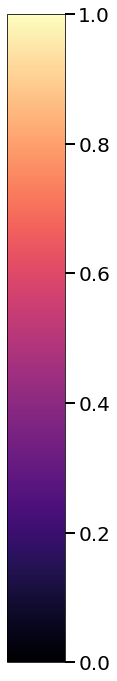

In [31]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(1, 15))
img = pl.imshow(a, cmap="magma")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
cbar = pl.colorbar(cax=cax)
cbar.ax.tick_params(labelsize=20, length=10, width=2)
pl.savefig("colorbar.png", dpi=300, bbox_inches='tight')